# Robot control Lab 3 - OpenCV poses and stereo

Todays lab will focus on extracting 3D information from images. During creation of this scenario Google Colab runs OpenCV version [4.8.0](https://docs.opencv.org/4.8.0/index.html), if you have a different version you can change docs version to match. If you want more materials or different approach to what will be presented in this scenario, [these materials](https://docs.opencv.org/4.6.0/d9/db7/tutorial_py_table_of_contents_calib3d.html) should talk about similar things.

## imports


In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
print(f"OpenCV version is: {cv2.__version__}")

# In Colab we need to use:
# from google.colab.patches import cv2_imshow

OpenCV version is: 4.11.0


In [8]:
def cv2_imshow(img):
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()

## Calibration parameters and undistortion


Today we will be working with a camera with given calibration parameters. This means someone else (maybe the manufacturer) performed the calibration procedure and supplied us with the results. As you probably remember from the lecture, the camera matrix, or calibration matrix looks like this:

\begin{align}
\left[\begin{array}{ccc}
f_{x} & 0 & c_{x}\\
0 & f_{y} & c_{y}\\
0 & 0 & 1
\end{array}\right]
\end{align}

You should also be familiar with radial and tangential distortions that can be represented with a vector of 5 numbers:

\begin{align}
\left(\begin{array}{ccccc}
k_{1} & k_{2} & p_{1} & p_{2} & k_{3}\end{array}\right)
\end{align}

More on that [here](https://docs.opencv.org/4.1.2/dc/dbb/tutorial_py_calibration.html).

In [5]:
camera_matrix = np.array([[528.86 ,   0.    , 641.865],
                          [  0.   , 528.755 , 360.867],
                          [  0.   ,   0.    ,   1.   ]])

dist_coeffs = np.array([-0.0420881, 0.0110919, -0.00090298, -0.00013151, -0.00534522])

Today asset pictures are **not** undistorted. We have calibration parameters, so this should not be a problem. 

To **undistort** the images we need undistorion maps. Note that if we compute undistortion maps for a camera on one image, we can use the same maps to undistort other images taken with the same camera. So we need to find the maps only once. 

We find the maps in two steps. First we derive a new camera matrix using [getOptimalNewCameraMatrix](https://docs.opencv.org/4.1.2/d9/d0c/group__calib3d.html#ga7a6c4e032c97f03ba747966e6ad862b1). Then, we use the obtained matrix to calculate undistortion maps. Check the code below to see how this can be done.  Try different values of alpha, like 0 and 1, and see how the results change. Choose the value you deem the best.

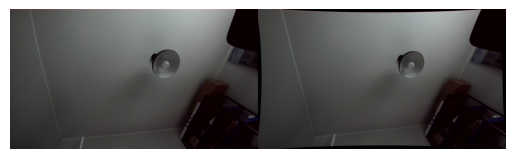

In [9]:
img0 = cv2.imread("0.png")

# OpenCV order
size = (img0.shape[1], img0.shape[0])

# Calculate undistorted camera matrix
alpha = 0.5 # TODO: try 0 and 1
rect_camera_matrix = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coeffs, size, alpha)[0]

# Calculate undistortion maps
map1, map2 = cv2.initUndistortRectifyMap(camera_matrix, dist_coeffs, np.eye(3), rect_camera_matrix, size, cv2.CV_32FC1)

# Use maps to undistort an image
rect_img0 = cv2.remap(img0, map1, map2, cv2.INTER_LINEAR)

# Show original and undistorted side by side
cv2_imshow(cv2.hconcat([img0, rect_img0]))

## Single image, single marker pose

### Quick recap, OpenCV names:

Pose = postition + orientation

Position is a 3D translation vector:
$\left[\begin{array}{c}d_{x}\\d_{y}\\d_{z}\end{array}\right]$, OpenCV will call this `tvec`.

Orientation can be expressed in many ways: rotation matrix, rotation vector, quaternion, euler angles (e.g. roll, pitch, yaw).

OpenCV most often works with rotation vector
$\left[\begin{array}{c}r_{x}\\r_{y}\\r_{z}\end{array}\right]$,
and calls it `rvec`.

OpenCV also provides [Rodrigues](https://docs.opencv.org/4.1.2/d9/d0c/group__calib3d.html#ga61585db663d9da06b68e70cfbf6a1eac) to convert `rvec` to and from the rotation matrix.

### Detecting the pose

As you remember from the lecture using pinhole camera model we can map a point in 3D world coordinates to a point on the image plane. The other direction is not so easy — point on the image plane gives us a line (light ray) in 3D on which this point in real world was. Now, we can use 4 corners of a marker, because we know their geometry, i.e. they lie on a single plane and form a square with a known side length.
The process looks like so: we take corners on the image and imagine 4 rays, then we fit a square in 3D so that each corner lies on a ray and side lengths match. This image can help you visualize the process:

![Projecting points into 3D](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F99B415455D9C2AE71F)
[Image source](https://ballentain.tistory.com/40)

We will use a function `my_estimatePoseSingleMarkers` that solves that for by utilizing `solvePnP` function from opencv. It takes corners, marker size, intrinsic matrix and array containing parameters of distortions.

Let's see how to use it:

corners=(array([[[303.9578 , 538.5204 ],
        [318.33008, 321.1211 ],
        [530.7316 , 326.73206],
        [530.6716 , 526.7862 ]]], dtype=float32),)


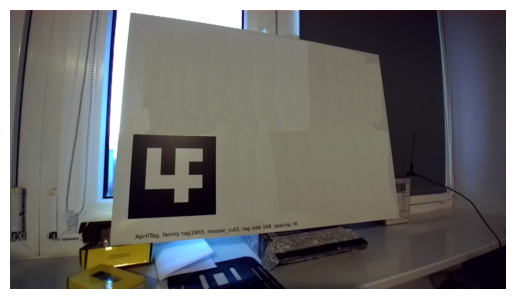

corner=array([303, 538])
corner=array([318, 321])
corner=array([530, 326])
corner=array([530, 526])


/tmp/ipykernel_38072/3853656113.py:65: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  corner = np.array(corners[0][0][i], dtype=np.integer)


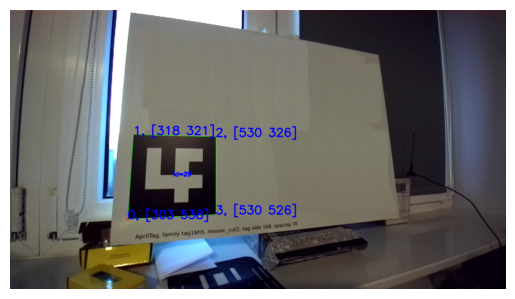

(array([[[303.9578 , 538.5204 ],
        [318.33008, 321.1211 ],
        [530.7316 , 326.73206],
        [530.6716 , 526.7862 ]]], dtype=float32),)
rvecs=[array([[-2.14965292],
       [ 2.17048931],
       [-0.45400417]])]
tvecs=[array([[-0.17523559],
       [ 0.05211466],
       [ 0.42396535]])]


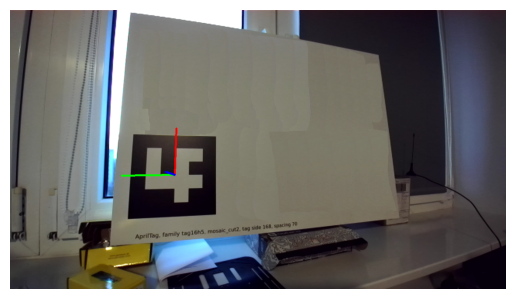

In [24]:
def my_estimatePoseSingleMarkers(corners, marker_size, mtx, distortion):
    '''
    This will estimate the rvec and tvec for each of the marker corners detected by:
       corners, ids, rejectedImgPoints = detector.detectMarkers(image)
    corners - is an array of detected corners for each detected marker in the image
    marker_size - is the size of the detected markers
    mtx - is the camera matrix
    distortion - is the camera distortion matrix
    RETURN list of rvecs, tvecs, and trash (so that it corresponds to the old estimatePoseSingleMarkers())

    stolen from stackoverflow
    '''
    marker_points = np.array([[-marker_size / 2, marker_size / 2, 0],
                              [marker_size / 2, marker_size / 2, 0],
                              [marker_size / 2, -marker_size / 2, 0],
                              [-marker_size / 2, -marker_size / 2, 0]], dtype=np.float32)
    trash = []
    rvecs = []
    tvecs = []
    for c in corners:
        nada, R, t = cv2.solvePnP(marker_points, c, mtx, distortion, False, cv2.SOLVEPNP_IPPE_SQUARE)
        rvecs.append(R)
        tvecs.append(t)
        trash.append(nada)
    return rvecs, tvecs, trash

# font
font = cv2.FONT_HERSHEY_SIMPLEX

# org
org = (50, 50)

# fontScale
fontScale = 1
 
# Blue color in BGR
color = (255, 0, 0)

# Line thickness of 2 px
thickness = 2

# Aruco detector parameters
dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_APRILTAG_16h5)
detectorParams = cv2.aruco.DetectorParameters()
detectorParams.cornerRefinementMethod = cv2.aruco.CORNER_REFINE_CONTOUR
detector = cv2.aruco.ArucoDetector(dictionary, detectorParams)

# Note that unit is not specified, we just need to stick to one (here meters)
MARKER_SIDE = 0.168

img1 = cv2.imread("1.png")
img1_draw = img1.copy()

corners, ids, _ = detector.detectMarkers(img1)

print(f"{corners=}")

# TODO: inspect the image and draw detection
cv2_imshow(img1_draw) 

cv2.aruco.drawDetectedMarkers(img1_draw, corners, ids)

for i in range(len(corners[0][0])):
    
    corner = np.array(corners[0][0][i], dtype=np.integer)
    print(f"{corner=}")
    
    img1_draw = cv2.putText(img1_draw, f"{i}, {corner}", corner, font, 
                   fontScale, color, thickness, cv2.LINE_AA)

cv2_imshow(img1_draw) 

# This takes multiple corners and calculates 3D pose
rvecs, tvecs, _ = my_estimatePoseSingleMarkers(corners, MARKER_SIDE, camera_matrix, dist_coeffs)

print(corners)


# TODO: inspect type and shape of rvecs and tvecs
print(f"{rvecs=}")
print(f"{tvecs=}")

# We can draw a pose using OpenCV
img1_draw = img1.copy()
cv2.drawFrameAxes(img1_draw, camera_matrix, dist_coeffs, rvecs[0], tvecs[0], 0.1)
cv2_imshow(img1_draw)

### Detections and undistortion

Notice that we did not undistort the image. Marker detection often runs just fine on distorted images, but we had to pass not only the camera matrix, but also distortion coeffs to every function that calculated things in 3D. This way we didn't have to explicitly undistort the whole image, which can be slow.

### Your turn, but undistort first

Now try to merge knowledge about undistortion and marker's pose detection and load image 2.png, undistort it, and then perform markers detection and pose calculation.

**Do not recalculate** things we already have: undistortion maps, undistorted camera matrix, marker detector parameters, marker size.

Note: remember that undistortion changes camera matrix and makes distortion coeffitiens zero, so you should use `rect_camera_matrix` after undistortion and you can just pass `0` as distCoeffs.



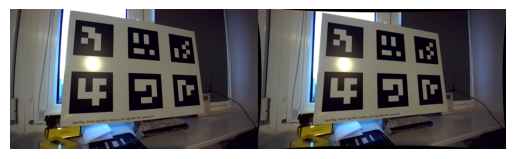

In [26]:
# TODO:
img2 = cv2.imread("2.png")


def undistort(img):
    # OpenCV order
    size = (img.shape[1], img.shape[0])

    # Calculate undistorted camera matrix
    alpha = 0.5 # TODO: try 0 and 1
    rect_camera_matrix = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coeffs, size, alpha)[0]

    # Calculate undistortion maps
    map1, map2 = cv2.initUndistortRectifyMap(camera_matrix, dist_coeffs, np.eye(3), rect_camera_matrix, size, cv2.CV_32FC1)

    # Use maps to undistort an image
    rect_img = cv2.remap(img, map1, map2, cv2.INTER_LINEAR)
    cv2_imshow(cv2.hconcat([img, rect_img]))
    
    return rect_img
    # Show original and undistorted side by side

rect_img2 = undistort(img2)

### Drawing

Just as in the last scenario we will draw 3D poses ourselves, but now in 3D!

We will use [projectPoints](https://docs.opencv.org/4.1.2/d9/d0c/group__calib3d.html#ga1019495a2c8d1743ed5cc23fa0daff8c) function, which takes object pose as `rvec` and `tvec` and an array of object points. Object points are just additional translations in object's frame of reference. For example, if we have object point `[42, 0, 0]` and will call `projectPoints` with some `rvec` and `tvec`, then the function will chain transormations from camera frame of reference first by `tvec`, then `rvec`, then translate in object's frame of reference by 42 in X direction and finally project resulting point to the image plane coordinates. For convenience the function can take multiple object points at once. Inspect the demo below:

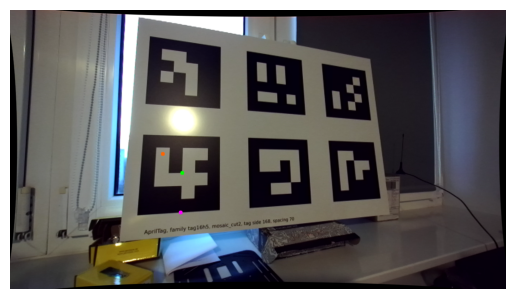

In [27]:
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
GREEN = (0, 255, 0)
DARK_GREEN = (0, 127, 0)
RED = (0, 0, 255)
BLUE = (255, 0, 0)
VIOLET = (255, 0, 255)
CYAN = (255, 255, 0)
YELLOW = (0, 255, 255)
ORANGE = (0, 100, 255)


objpts = np.array([[0, 0, 0], [-0.5, 0, 0], [0.25, 0.25, 0]]) * MARKER_SIDE

imgpts = np.rint(cv2.projectPoints(objpts, rvecs[0], tvecs[0], rect_camera_matrix, 0,)[0]).astype(int)
imgpts = imgpts.reshape((-1, 2))

rect_img2_draw = rect_img2.copy()

cv2.circle(rect_img2_draw, (imgpts[0][0], imgpts[0][1]), 5, GREEN, -1);
cv2.circle(rect_img2_draw, (imgpts[1][0], imgpts[1][1]), 5, VIOLET, -1);
cv2.circle(rect_img2_draw, (imgpts[2][0], imgpts[2][1]), 5, ORANGE, -1);

cv2_imshow(rect_img2_draw)

### Your turn! Drawing cubes

On the `rect_img2` try to calculate and draw points in a cube pattern, like so:

![cubes](https://github.com/nomagiclab/lab6_assets/raw/master/cubes.png)


You will definitely need an array of object points that designate 8 cube corners, `rvecs` and `tvecs` (use calculated ones), `projectPoints` function and some drawing functions.

You might be interested in `drawContours` function (search the docs!), but note that it takes list of contours and a contour is a list of points. This function lets you fill the contour, like the blue square in the example above or draw only the outline, like the red square in the example above.

Remember to pass coordines of `int` type to OpenCV drawing functions. Also, some of them, like `line`, expect coordinates as a tuples, not lists or arrays (`drawContours` does not care).

/tmp/ipykernel_38072/3029600748.py:15: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  imgpts = np.array(imgpts, dtype=np.integer)
/tmp/ipykernel_38072/3029600748.py:34: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  imgpts = np.array(imgpts, dtype=np.integer)


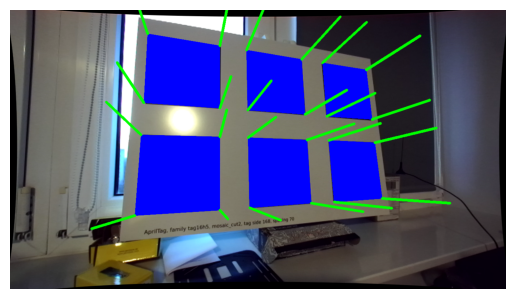

Ellipsis

In [53]:
# TODO:

img_cpy = np.copy(rect_img2)
corners, ids, _ = detector.detectMarkers(img_cpy)
rvecs, tvecs, _ = my_estimatePoseSingleMarkers(corners, MARKER_SIDE, camera_matrix, dist_coeffs)

def draw_blue_square(img, rvec, tvec):
    points = np.array([
        [-0.5, -0.5, 0],
        [-0.5, 0.5, 0],
        [0.5, 0.5, 0],
        [0.5, -0.5, 0]
    ]) * MARKER_SIDE
    imgpts, _ = cv2.projectPoints(points, rvec, tvec, camera_matrix, 0)
    imgpts = np.array(imgpts, dtype=np.integer)
    imgpts = imgpts.reshape((-1, 2))
    return cv2.fillPoly(img, [imgpts], BLUE)

def draw_green_bars(img, rvec, tvec):
    bar = np.array([
        [0, 0, 0],
        [0, 0, 1]
    ]) * MARKER_SIDE
    corners = np.array([
        [-0.5, -0.5, 0],
        [-0.5, 0.5, 0],
        [0.5, 0.5, 0],
        [0.5, -0.5, 0]
    ]) * MARKER_SIDE
    
    for corner in corners:
        points = bar + corner
        imgpts, _ = cv2.projectPoints(points, rvec, tvec, camera_matrix, 0)
        imgpts = np.array(imgpts, dtype=np.integer)
        imgpts = imgpts.reshape((1, -1, 2))
        img =  cv2.polylines(img, imgpts, True, GREEN, 5)
    return img

def draw_red_squares(img, rvec, tvec):
    corners = np.array([
        [-0.5, -0.5, 1],
        [-0.5, 0.5, 1],
        [0.5, 0.5, 1],
        [0.5, -0.5, 1]
    ]) * MARKER_SIDE
    
    imgpts, _ = cv2.projectPoints(corners, rvec, tvec, camera_matrix, 0)
    imgpts = np.array(imgpts, dtype=np.integer)
    imgpts = imgpts.reshape((1, -1, 2))
    return cv2.polylines(img, imgpts, True, RED, 5)


for rvec, tvec in zip(rvecs, tvecs):
    img_cpy = draw_blue_square(img_cpy, rvec, tvec)
    
for rvec, tvec in zip(rvecs, tvecs):
    img_cpy = draw_green_bars(img_cpy, rvec, tvec)
    
for rvec, tvec in zip(rvecs, tvecs):
    img_cpy = draw_red_squares(img_cpy, rvec, tvec)
    
    
cv2_imshow(img_cpy)

...